In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import segpath2path, pairwise_distances, point2segments

In [2]:
record_dir = 'straight_route_following' 
var_name = 'noise_motor'
ls_value = -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
n_condition = len(ls_value)
catchment_radius = 0.372 / 2 ## 0.372 is the wheel axle length of Freight

In [3]:
n_trial = 100
n_epoch_train, n_epoch_test = 180, 250
goal_idx = -1
ls_model_keys = 'pure-pursuit', 'visual-localisor', 'lamb'
ls_model_name = 'pure-pursuit', 'visual-localisor', 'differential-MB'
ls_color = 'tab:blue', 'tab:orange', 'tab:green'

In [4]:
data_path = np.load(os.path.join('records', record_dir, 'data_path.npy'), allow_pickle=True)[()]

In [5]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}
data_time_catchment = {}

for model_name in ls_model_name:
    data_path[model_name]['test'] = (data_path[model_name]['test'].T - data_path[model_name]['test'][:, :, :, 0].T).T
    path_train_init = data_path[model_name]['train'][:, :, :, 0]
    data_path[model_name]['train'] = (data_path[model_name]['train'].T - path_train_init.T).T
    path_train_goal = data_path[model_name]['train'][:, :, :, -1]
    dist_init2goal = np.linalg.norm(path_train_goal, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'], axis=2)
    time_min_dist2goal = np.nanargmin(dist_test2goal, axis=2)
    min_dist2goal = np.nanmin(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)
    data_path[model_name]['test_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['test'])

    time_catchment = np.argmax(dist_test2goal <= catchment_radius, axis=-1)
    data_time_catchment[model_name] = np.where(time_catchment == 0, np.nan, time_catchment)
    
    ### base
    data_path[model_name]['base'] = (data_path[model_name]['base'].T - data_path[model_name]['base'][:, :, :, 0].T).T
    dist_base2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['base'], axis=2)
    time_min_dist2goal = np.argmin(dist_base2goal, axis=2)
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_path[model_name]['base_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['base'])

In [6]:
data_dsim_test2train, data_dist_test2path = {}, {}

for model_name in ls_model_name:
    model_dsim_test2train, model_dist_test2path = [], []
    for path_train_val, path_test_val, time_mindist_test2goal_val in zip(data_path[model_name]['train'], 
                                                                          data_path[model_name]['test_trunc'],
                                                                          data_time_min_dist2goal[model_name]):
        val_time_mindist = []
        val_dist_test2path = np.full((n_trial, n_epoch_test), np.nan)
        for trial_idx, (path_train_trial, path_test_trial, time_mindist) in enumerate(zip(path_train_val, 
                                                                                        path_test_val, 
                                                                                        time_mindist_test2goal_val)):
            dsim_test2train, dist_test2path = segpath2path(path_test_trial.T[:time_mindist + 1], path_train_trial.T)
            val_time_mindist.append(dsim_test2train)
            val_dist_test2path[trial_idx, :time_mindist + 1] = dist_test2path
        model_dsim_test2train.append(val_time_mindist)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dsim_test2train[model_name] = np.array(model_dsim_test2train)
    data_dist_test2path[model_name] = np.array(model_dist_test2path)

data_dsim_test2train = {}    

for model_name in ls_model_name:
    model_dsim_test2train = []
    for path_train_val, path_test_val, time_mindist_test2goal_val in zip(data_path[model_name]['train'], 
                                                                          data_path[model_name]['test_trunc'],
                                                                          data_time_min_dist2goal[model_name]):
        val_time_mindist = []
        for path_train_trial, path_test_trial, time_mindist in zip(path_train_val, path_test_val, time_mindist_test2goal_val):
            dsim_test2train = segpath2path(path_test_trial.T[:time_mindist + 1], path_train_trial.T)
            val_time_mindist.append(dsim_test2train)
        model_dsim_test2train.append(val_time_mindist)
        
    data_dsim_test2train[model_name] = np.array(model_dsim_test2train)
#################### dsim

data_dist_test2path, data_dist_test2line = {}, {}

for model_name in ls_model_name:
    model_dist_test2path, model_dist_test2line = [], []
    for path_train_val, path_test_val in zip(data_path[model_name]['train'], data_path[model_name]['test_trunc']):
        val_dist_test2path, val_dist_test2line = [], []
        for path_train_trial, path_test_trial in zip(path_train_val, path_test_val):
            dist_test2path = [point2segments(xy, path_train_trial.T) for xy in path_test_trial.T]
            val_dist_test2path.append(dist_test2path)
            dist_test2line = [point2segments(xy, path_train_trial.T[[0, -1]]) for xy in path_test_trial.T]
            val_dist_test2line.append(dist_test2line)
        model_dist_test2line.append(val_dist_test2line)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dist_test2path[model_name] = np.array(model_dist_test2path)
    data_dist_test2line[model_name] = np.array(model_dist_test2line)

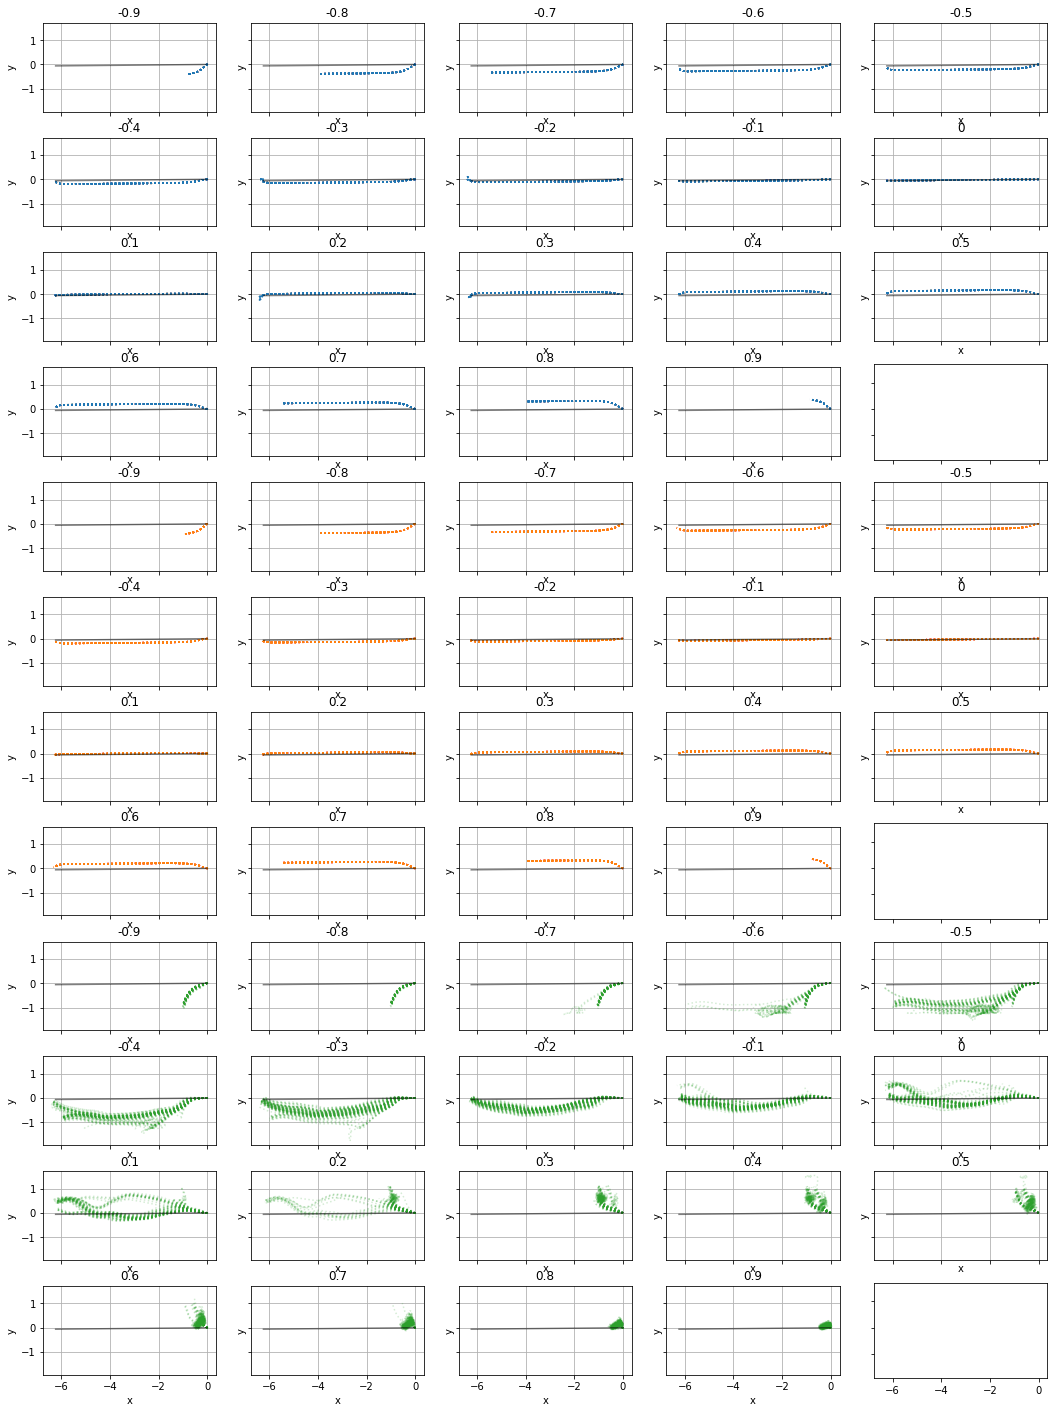

In [7]:
fig, axes = plt.subplots(12, 5, sharex=True, sharey=True, figsize=(18, 25))
axgroup = axes.reshape(3, 4, 5)

for model_name, axrow, color in zip(ls_model_name, axgroup, ls_color):
    for dtp_train, dtp_testtrunc, val, ax in zip(data_path[model_name]['train'], 
                                                            data_path[model_name]['test_trunc'],
                                                            ls_value, axrow.flatten()):
        for trial_idx, (path_train, path_test_trunc) in enumerate(zip(dtp_train, dtp_testtrunc)):
            if trial_idx % 1 == 0:
                ax.plot(*path_test_trunc, c=color, alpha=0.2, ls='dotted')
        
        ax.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)


for xrow in axgroup:
    xrow[1, 0].set_ylabel('{}\ny'.format(model_name))
    for xx, val in zip(xrow.flatten(), ls_value):
        xx.set_xlabel('x')
        xx.set_ylabel('y')
        xx.set_aspect('equal')    
        xx.set_title(val)
        xx.grid()

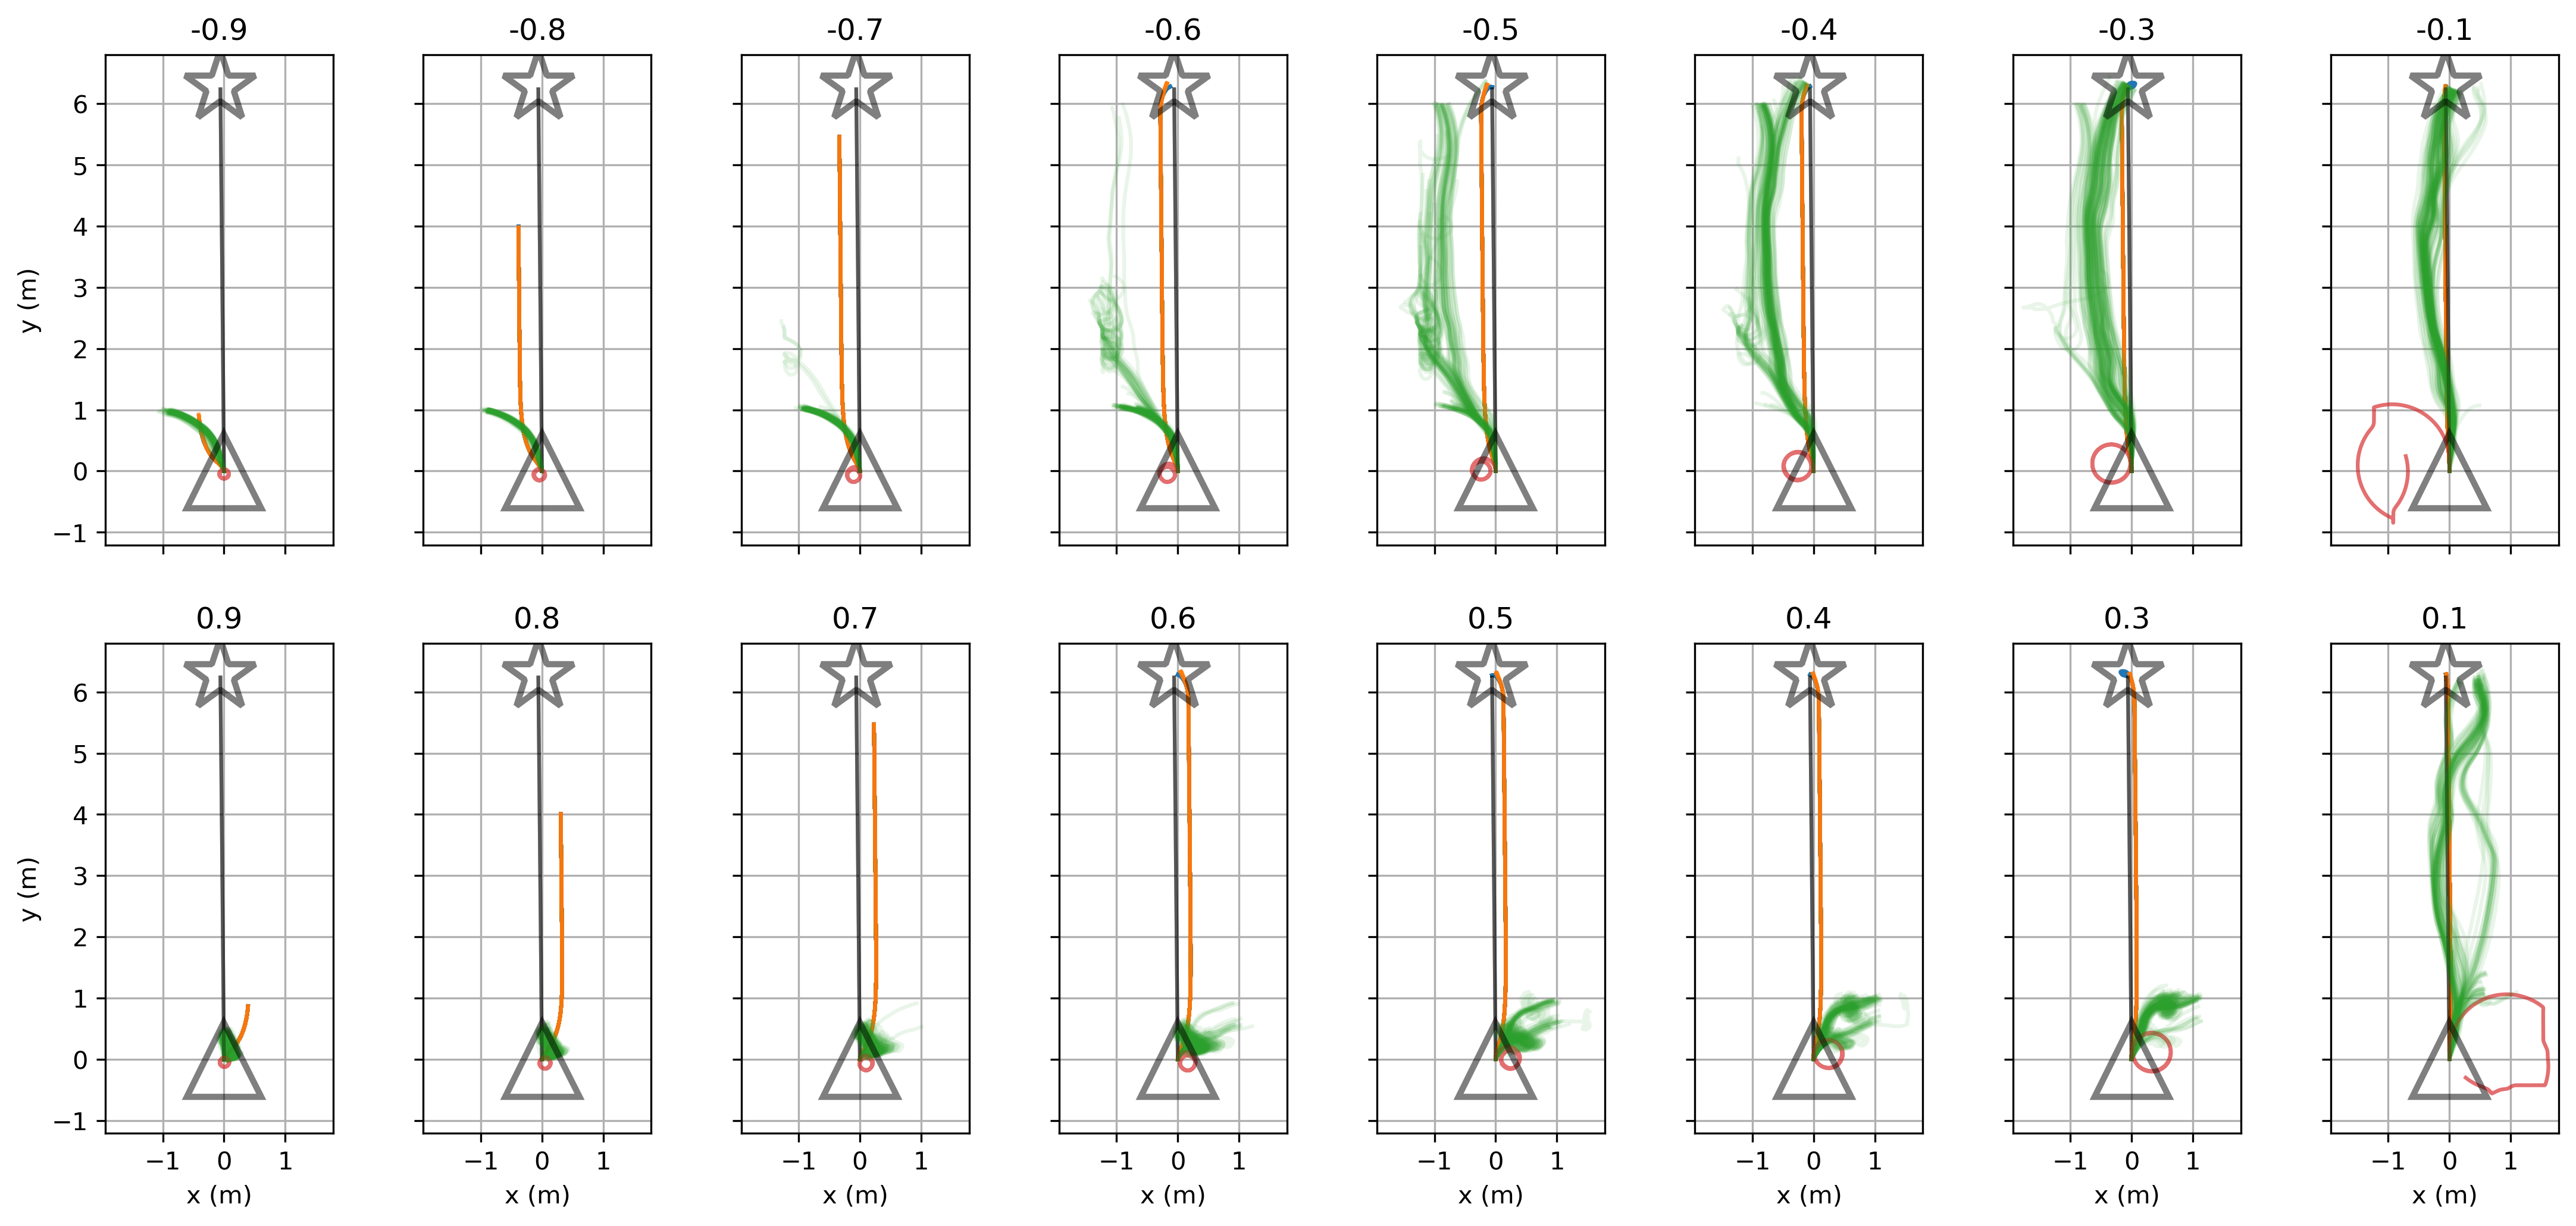

In [12]:
fig, axes = plt.subplot_mosaic('''
                                ABCDEFGI
                                abcdefgi
                                ''', sharex=True, sharey=True, figsize=(18, 8), dpi=300)
lw = 5

for model_name, color in zip(ls_model_name, ls_color):
    for dtp_base, dtp_train, dtp_testtrunc, val, ak in zip(data_path[model_name]['base'],
                                                           data_path[model_name]['train'], 
                                                           data_path[model_name]['test_trunc'],
                                                           ls_value, 'ABCDEFGHIJihgfedcba'):
        
        if ak not in 'JHh':
            ax = axes[ak]
            for trial_idx, (path_base, path_train, path_test_trunc) in enumerate(zip(dtp_base, dtp_train, dtp_testtrunc)):
                if trial_idx % 1 == 0:
                    ax.plot(path_test_trunc[1], -path_test_trunc[0], c=color, alpha=0.1)#, ls='dotted')

            ax.plot(path_train[1, :goal_idx], -path_train[0, :goal_idx], c='k', alpha=0.3)
            ax.plot(path_base[1, :180], -path_base[0, :180], c='tab:red', alpha=0.3)
            
            if model_name == 'differential-MB':
                ax.plot(path_train[:, goal_idx][1], -path_train[:, goal_idx][0], c='k', alpha=0.5, 
                        marker='*', markersize=30, mfc='none', markeredgewidth=lw/2)
                ax.plot(path_train[:, 0][1], -path_train[:, 0][0], c='k', alpha=0.5,
                        marker='^', markersize=30, mfc='none', markeredgewidth=lw/2)
    


for ak, val in zip('ABCDEFGHIJihgfedcba', ls_value):
    if ak not in 'JHh':
        ax = axes[ak]
        if ak in 'abcdefghi': axes[ak].set_xlabel('x (m)')
        if ak in 'Aa': ax.set_ylabel('y (m)')
        ax.set_aspect('equal')    
        ax.grid()
        ax.set_title(val)

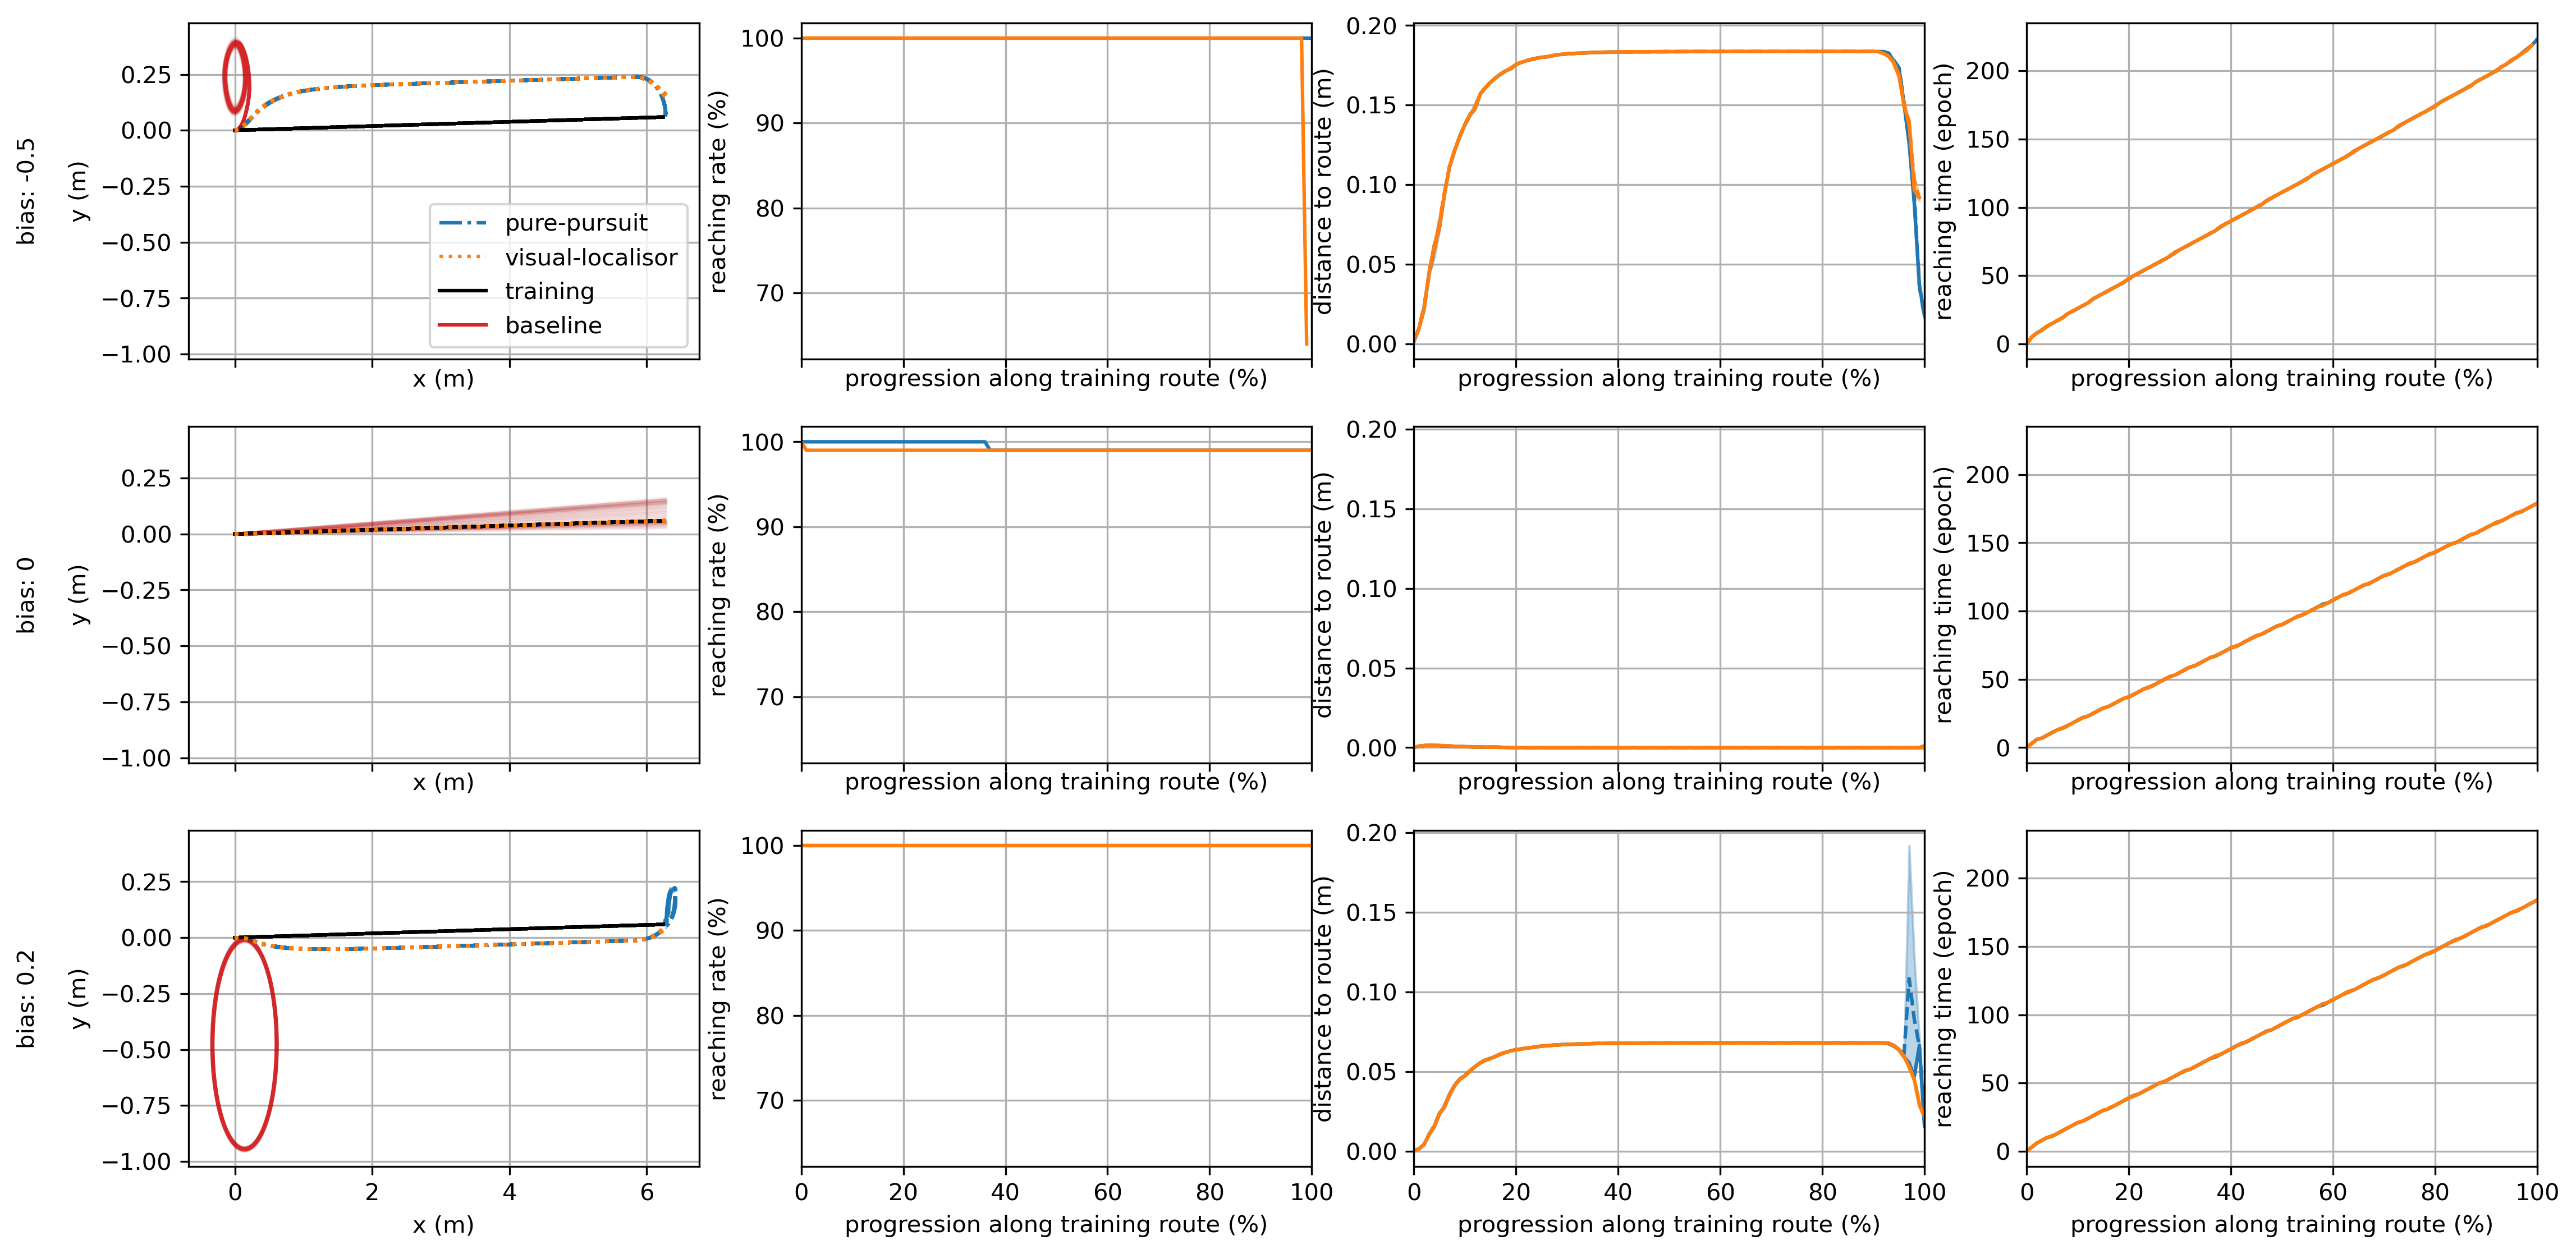

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(18, 9), sharex='col', sharey='col', dpi=300)

ls_validx = 4, 9, 11


for validx, ax in zip(ls_validx, axes.T[0]):
    for model_name, color, linestyle in zip(ls_model_name, ls_color[:2], ('-.', 'dotted')):
        dtp_base, dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('base', 'train', 'test', 'test_trunc')]
        for trial_idx, (path_base, path_train, path_test, path_test_trunc) in enumerate(zip(dtp_base, dtp_train, dtp_test, dtp_test_trunc)):
            if trial_idx % 1 == 0:
                ax.plot(-path_test_trunc[0], -path_test_trunc[1], c=color, alpha=0.5, ls=linestyle)
                ax.plot(-path_base[0, :180], -path_base[1, :180], c='tab:red', alpha=0.01)
                ax.plot(-path_train[:, :goal_idx][0], -path_train[:, :goal_idx][1], c='k', alpha=0.01)


        ax.plot([], [], c=color, ls=linestyle, label=model_name)
    ax.plot([], [], c='k', label='training')
    ax.plot([], [], c='tab:red', label='baseline')

    ax.set_xlabel('x (m)')
    ax.set_ylabel('bias: {}\n\ny (m)'.format(ls_value[validx]))
#     ax.set_xticks(np.arange(-1, 3.1, 1))
#     ax.set_yticks(np.arange(0, 2.1, 1))
#     ax.set_xlim(-1.5, 3.5)
#     ax.set_ylim(-1.3, 1.6)
#     ax.set_aspect('equal')    
#     ax.legend(loc=4)
    ax.grid()


for validx, axrow in zip(ls_validx, axes):
    bx, ax, cx = axrow[1:]
    for model_name, color in zip(ls_model_name, ls_color[:2]):
        dist_test2goal, dist_test2path = data_dist_test2goal[model_name][validx], data_dist_test2path[model_name][validx]
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
        progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

        val_test2path, val_n_point = [], []
        val_ptime = []
        for trial_progress, trial_test2path in zip(progress, dist_test2path):
            px, pxidx, pxinv = np.unique(trial_progress, return_index=True, return_inverse=True)
            pxinvsort = np.argsort(pxinv)
            t2p_interp = np.interp(progress_step, pxinv[pxinvsort], trial_test2path[pxinvsort], left=np.nan, right=np.nan)
            val_test2path.append(t2p_interp)
            val_n_point.extend(px)

            ptime = np.full_like(progress_step, np.nan)
            ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
            val_ptime.append(ptime)


        ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
        ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)

        ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)

        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        bx.plot(p_reach, n_reach, color=color, label=model_name)
        
        cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
        cx.plot(progress_step, np.nanmedian(val_ptime, axis=0), color=color)
        cx.fill_between(progress_step, *np.nanquantile(val_ptime, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        
    for ax, yl in zip(axrow[1:], ('reaching rate (%)', 'distance to route (m)', 'reaching time (epoch)')):
        ax.set_xlim(0, 100)
        ax.grid()
        ax.set_ylabel(yl)
        ax.set_xlabel('progression along training route (%)')


axes[0, 0].legend(loc=4)
# axes[1, 1].set_ylim(-0.02, 0.32)
# axes[1, 1].set_yticks(np.arange(0, 0.31, 0.1))
# axes[1, 2].set_ylim(-20, 420)
# axes[1, 2].set_yticks(np.arange(0, 401, 100))

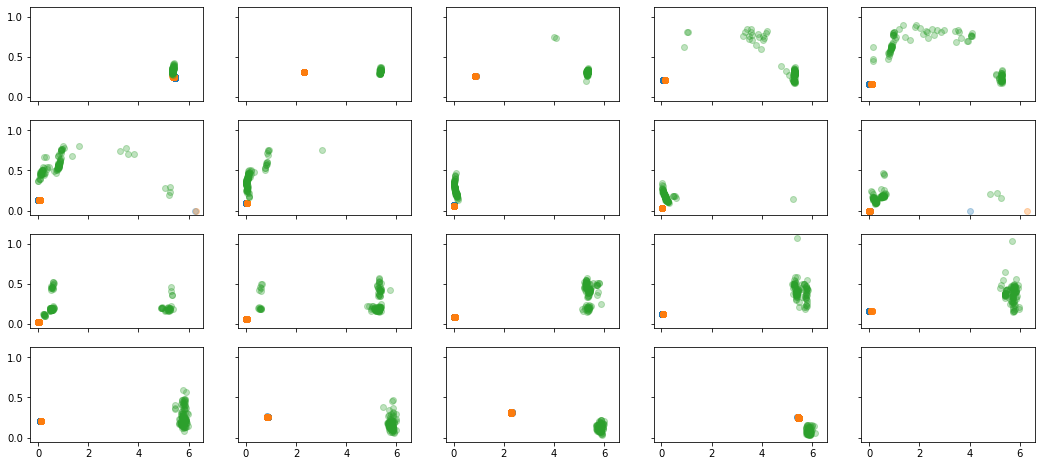

In [14]:
fig, axes = plt.subplots(4, 5, figsize=(18, 8), sharex=True, sharey=True)

n_catch = []

for model_name, color in zip(ls_model_name, ls_color):
    for ax, dsim_val, mind_val, in zip(axes.flatten(), data_dsim_test2train[model_name], data_min_dist2goal[model_name]):
        ax.scatter(mind_val, dsim_val, color=color, alpha=0.3)
        n_catch.append(np.count_nonzero(mind_val <= catchment_radius))
        
# for ax in axes.flatten():
#     ax.set_xscale('log')
#     ax.axvline(catchment_radius)
#     ax.set_yscale('log')

n_catch = np.reshape(n_catch, (3, n_condition))

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-15-d07b3582944d>:7: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(data, axis=1)
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-15-d07b3582944d>:7: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(data, axis=1)


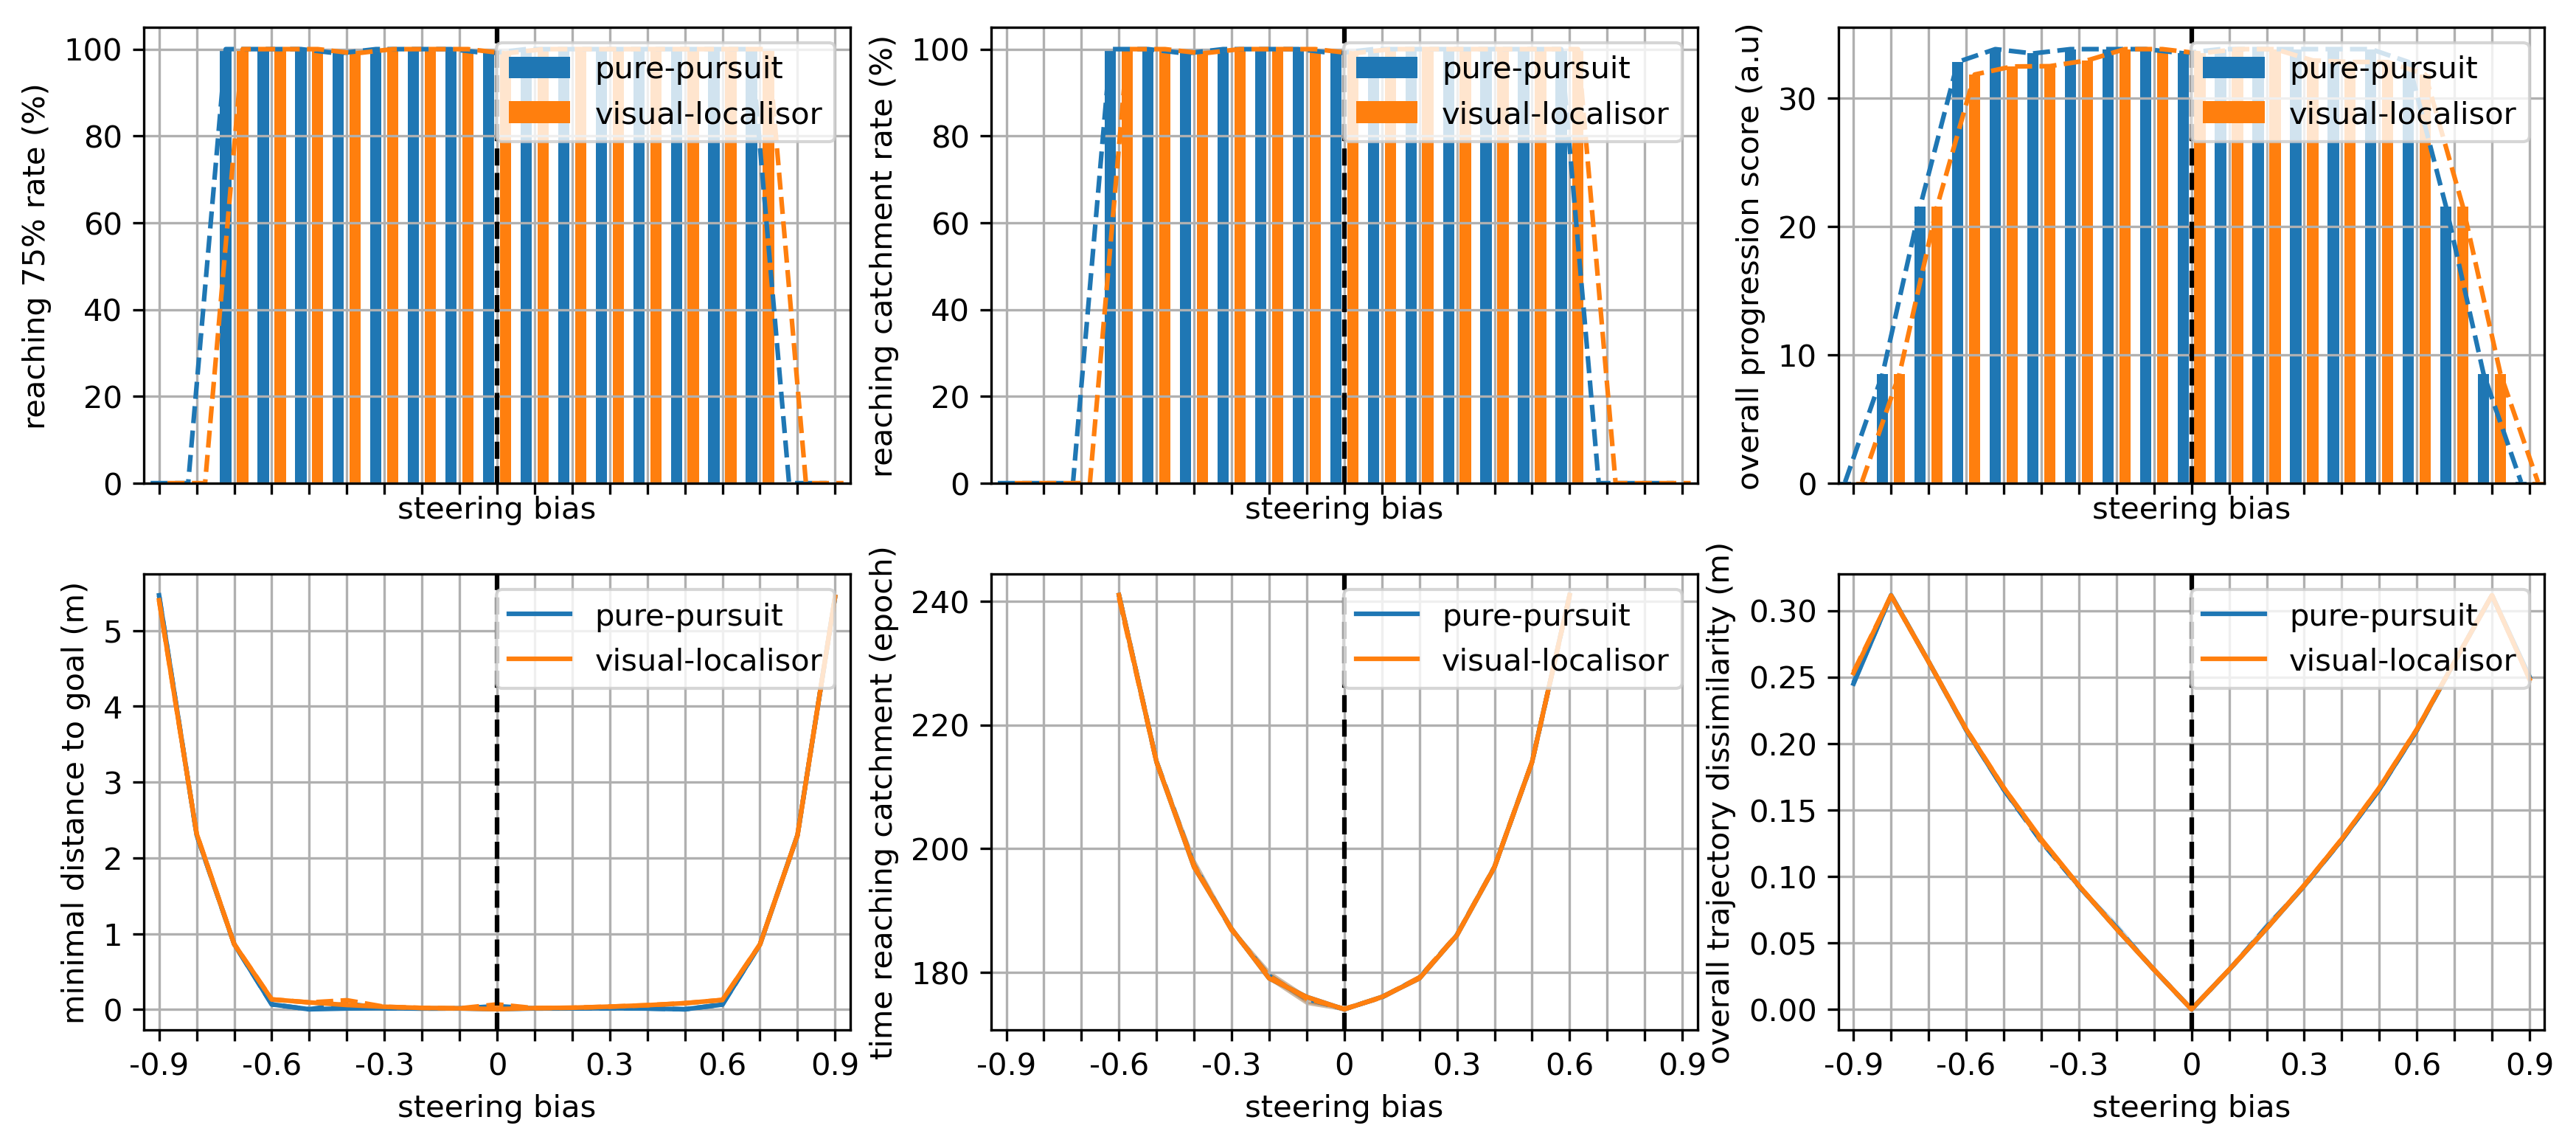

In [15]:
n_model = 2
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex=True, dpi=300)

for model_name, color in zip(ls_model_name[:n_model], ls_color):
    for ax, data in zip(axes[1], (data_min_dist2goal[model_name], data_time_catchment[model_name], data_dsim_test2train[model_name])):
        quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
        avg = np.nanmean(data, axis=1)
        ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
        ax.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)


for xoffset, model_name, color, nc in zip(np.arange(n_model) - n_model / 2 + 0.5, ls_model_name, ls_color, n_catch):
    area_success, n_reach_75 = [], []
    for dist_test2goal, dist_test2path in zip(data_dist_test2goal[model_name], data_dist_test2path[model_name]):
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
        progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

        val_n_point = []
        for trial_progress in progress:
            px = np.unique(trial_progress)
            val_n_point.extend(px)

        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        
        p_reach_75idx = np.nonzero(p_reach >= 75)[0]
        if len(p_reach_75idx) > 0:
            n_reach_75.append(n_reach[p_reach_75idx[0]])
        else:
            n_reach_75.append(0)
        
        p_reach_posidx = np.nonzero(p_reach > 0)
        n_reach_pos = np.interp(np.arange(101), p_reach[p_reach_posidx], n_reach[p_reach_posidx], left=100, right=0)
        
#         area_success.append(np.dot(np.arange(101) / 100, n_reach_pos / 100))
        area_success.append(np.dot((np.arange(101) / 100) ** 2, n_reach_pos / 100))
        
    wd = 0.6 / n_model
    xbar = np.arange(n_condition) + xoffset * wd * 1.5
    for ax, yy in zip(axes[0], (n_reach_75, nc, area_success)):
        ax.bar(xbar, yy, label=model_name, width=wd, color=color)
        ax.plot(xbar, yy, ls='dashed', color=color)
    
for ax, yl in zip(axes.flatten(), 
                  ('reaching 75% rate (%)', 
                   'reaching catchment rate (%)', 
                   'overall progression score (a.u)',
                   'minimal distance to goal (m)', 
                   'time reaching catchment (epoch)',
                   'overall trajectory dissimilarity (m)')):
    ax.set_ylabel(yl)
    
# for ax in axes[:-1]:
#     ax.set_ylim(top=102)

for ax in axes.flatten():
    ax.axvline(9, color='k', ls='dashed')
    ax.legend(loc=1)
    ax.grid()
    ax.set_xticks(np.arange(n_condition), [-0.9, '', '', -0.6, '', '', -0.3, '', '', 0, '', '', 0.3, '', '', 0.6, '', '', 0.9])
    ax.set_xlim(-0.4, 18.4)
    ax.set_xlabel('steering bias')

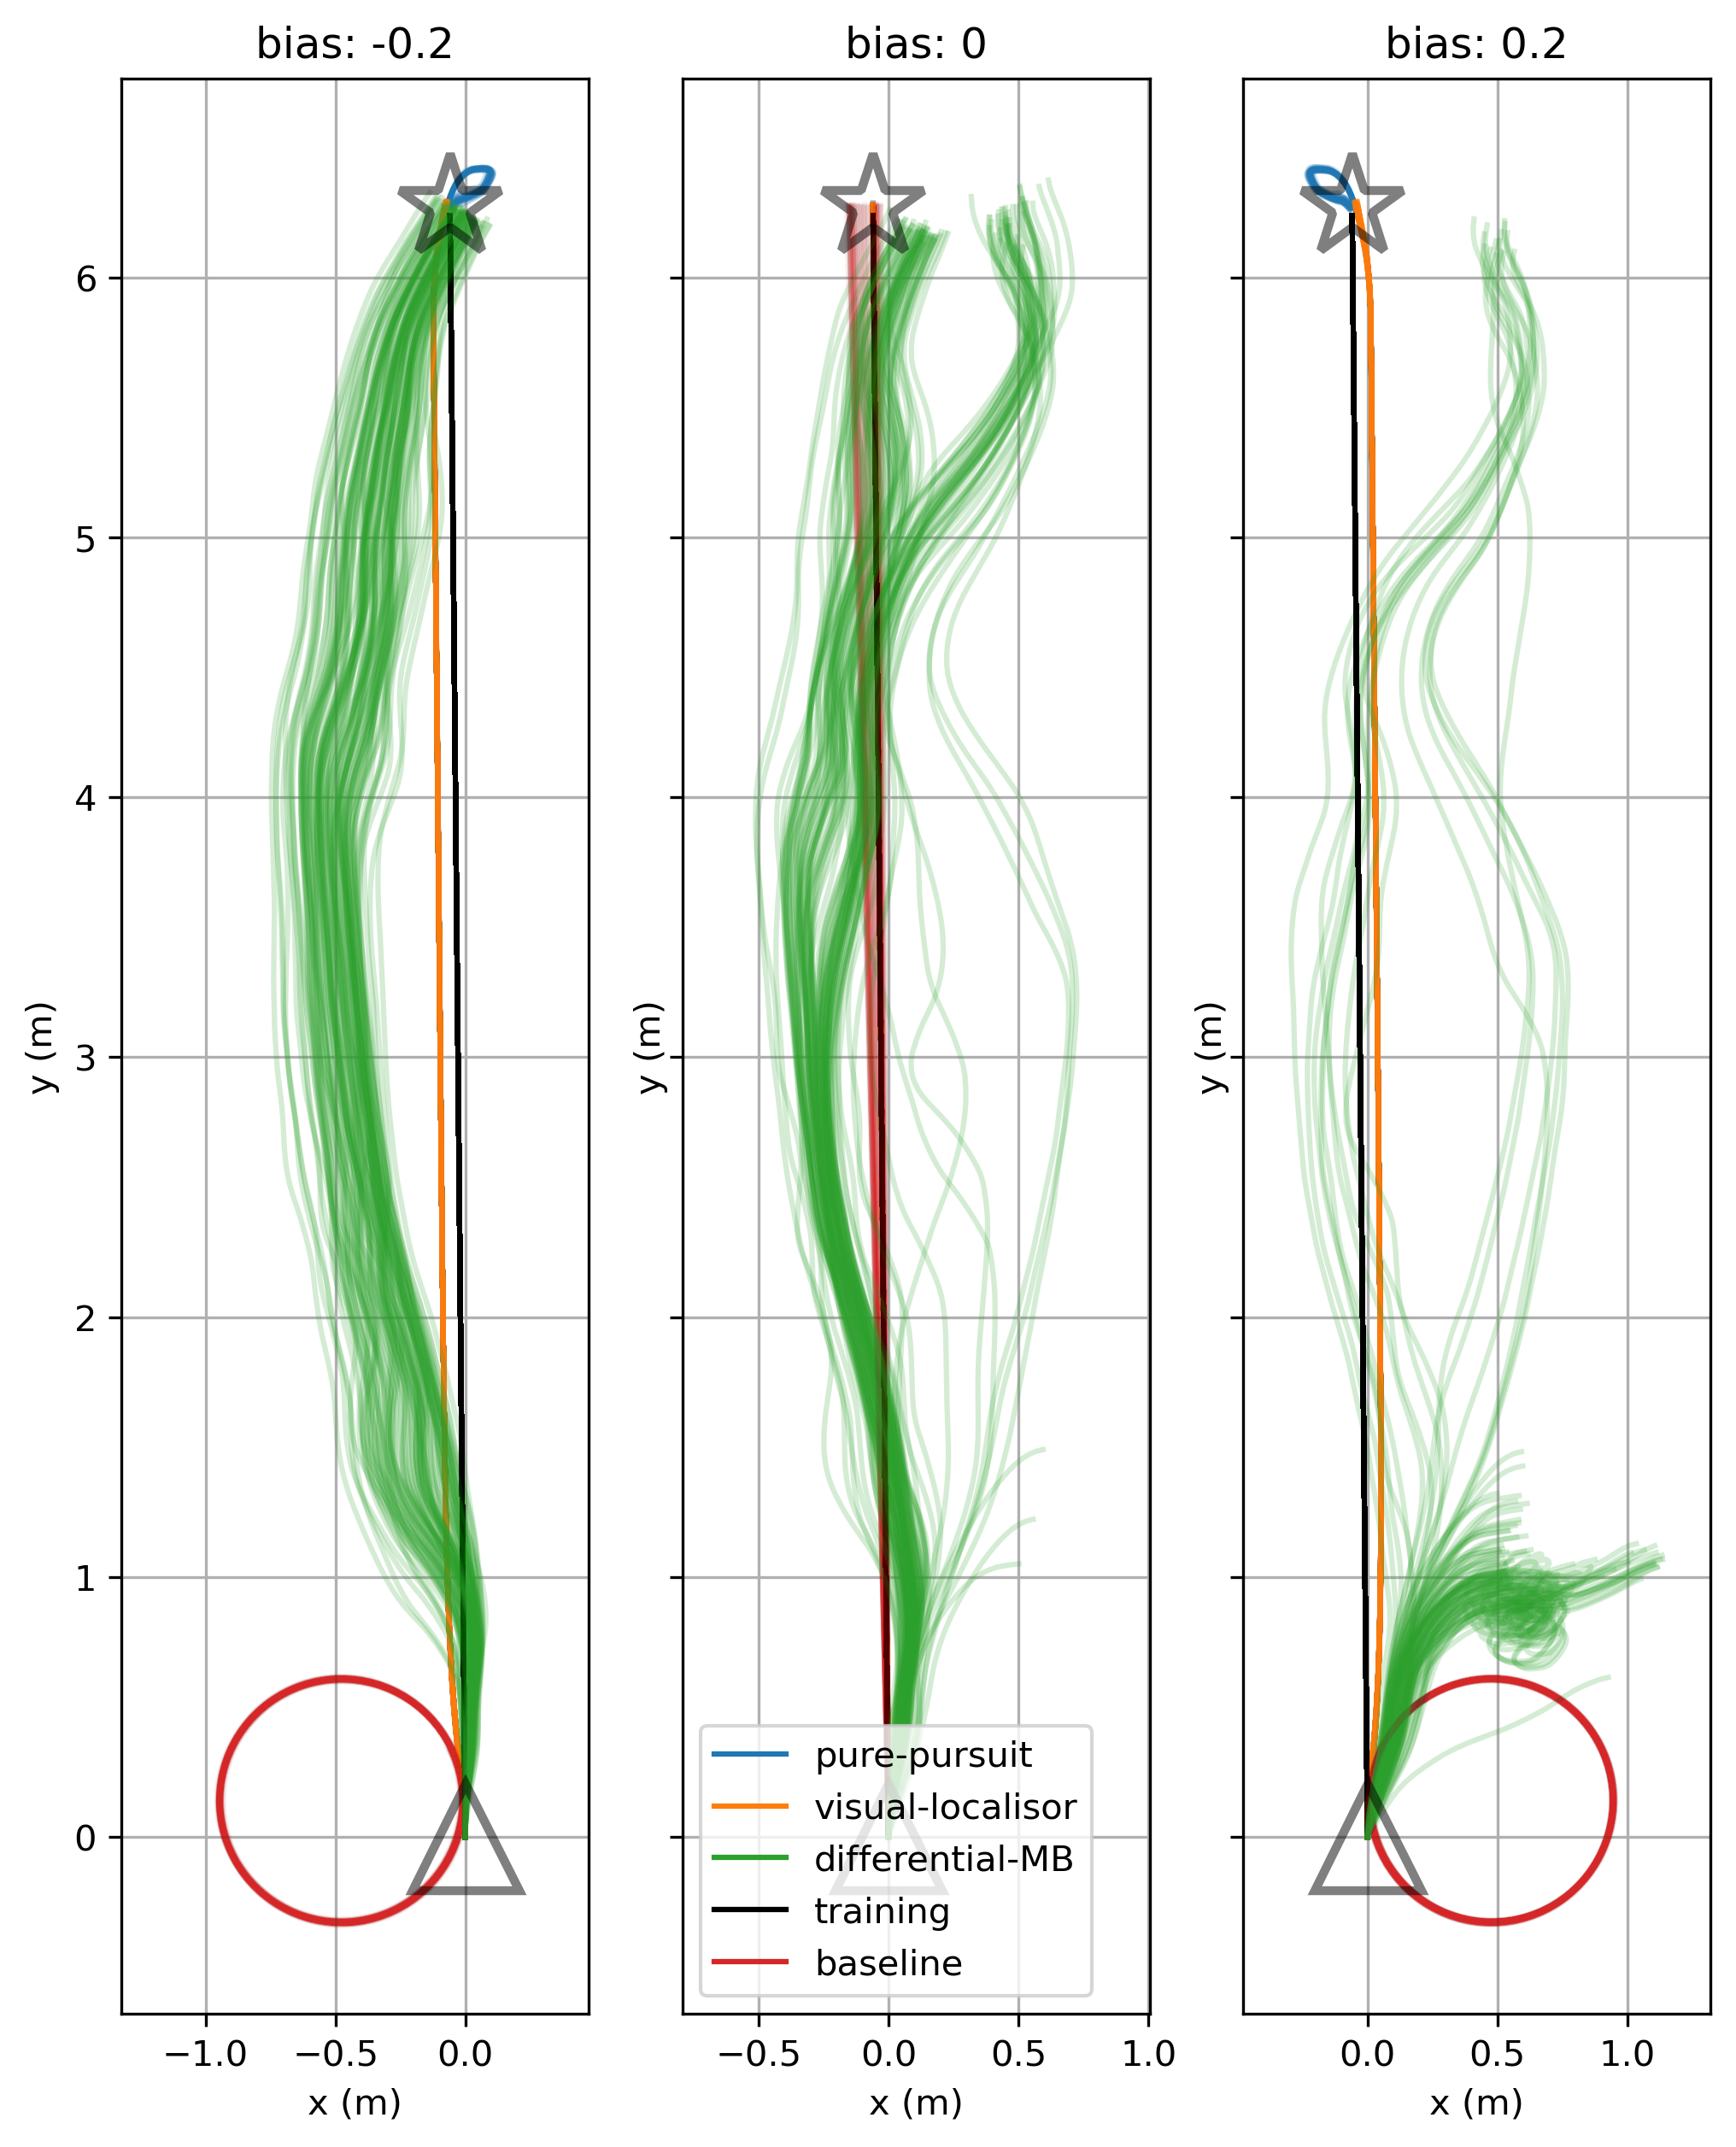

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(8, 10), sharey=True, dpi=300)

lw = 5

ls_validx = 7, 9, 11


for validx, ax in zip(ls_validx, axes):
    for model_name, color in zip(ls_model_name, ls_color):
        dtp_base, dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('base', 'train', 'test', 'test_trunc')]
        for trial_idx, (path_base, path_train, path_test, path_test_trunc) in enumerate(zip(dtp_base, dtp_train, dtp_test, dtp_test_trunc)):
            if trial_idx % 1 == 0:
                ax.plot(path_train[:, :goal_idx][1], -path_train[:, :goal_idx][0], c='k', alpha=0.01)
                ax.plot(path_base[1, :180], -path_base[0, :180], c='tab:red', alpha=0.01)
#                 ax.plot(path_test_trunc[1], -path_test_trunc[0], c=color, alpha=0.5, ls='dotted', lw=lw)
                ax.plot(path_test_trunc[1], -path_test_trunc[0], c=color, alpha=0.2)

        ax.plot([], [], c=color, label=model_name)
    ax.plot(path_train[:, goal_idx][1], -path_train[:, goal_idx][0], c='k', alpha=0.5, 
            marker='*', markersize=30, mfc='none', markeredgewidth=lw/2)
    ax.plot(path_train[:, 0][1], -path_train[:, 0][0], c='k', alpha=0.5,
            marker='^', markersize=30, mfc='none', markeredgewidth=lw/2)
    ax.plot([], [], c='k', label='training')
    ax.plot([], [], c='tab:red', label='baseline')

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('bias: {}'.format(ls_value[validx]))
    ax.set_aspect('equal', adjustable='datalim', share=True)    
    ax.grid()
    
axes[1].legend()

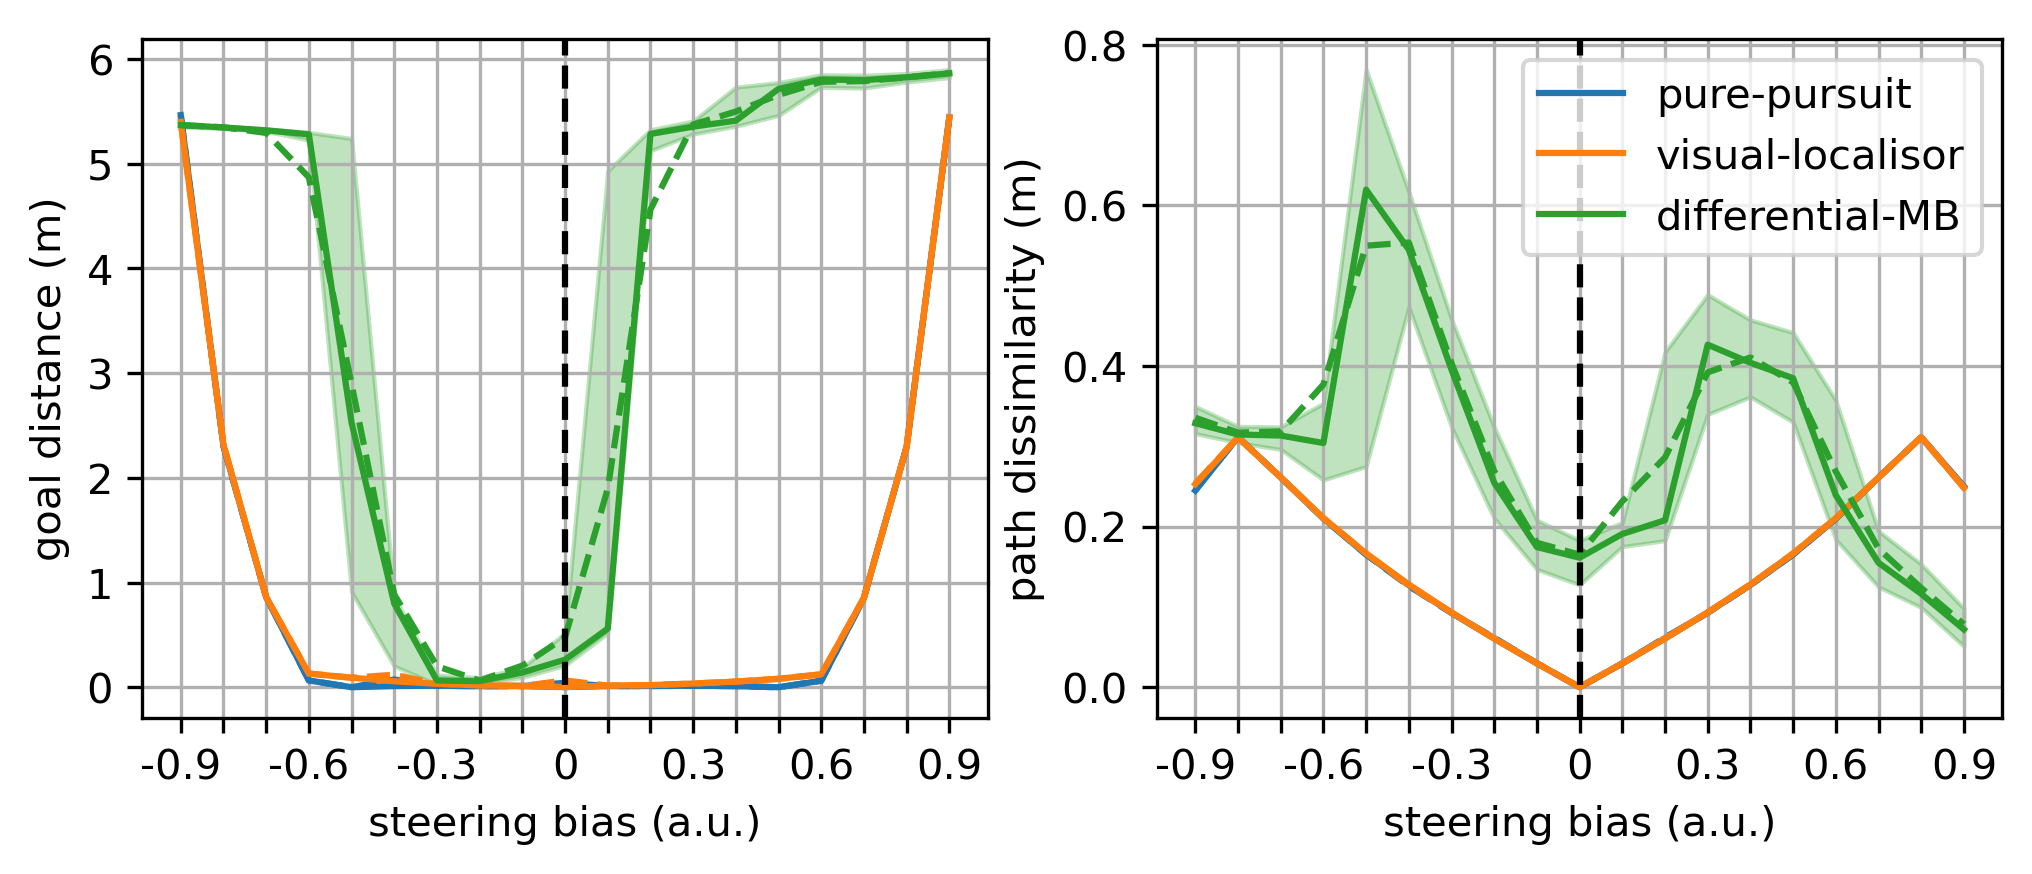

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)


for model_name, color in zip(ls_model_name, ls_color):
    for ax, data in zip(axes, (data_min_dist2goal[model_name], data_dsim_test2train[model_name])):
        quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
        avg = np.nanmean(data, axis=1)
        ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
        ax.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)

    
for ax, yl in zip(axes, ('goal distance (m)', 'path dissimilarity (m)')):
    ax.axvline(9, color='k', ls='dashed')
    ax.set_ylabel(yl)
    ax.grid()
#     ax.set_xticks(np.arange(0, n_condition, 3), np.array(ls_value)[np.arange(0, n_condition, 3)])
    ax.set_xticks(np.arange(n_condition), [-0.9, '', '', -0.6, '', '', -0.3, '', '', 0, '', '', 0.3, '', '', 0.6, '', '', 0.9])
    ax.set_xlabel('steering bias (a.u.)')
    
axes[1].legend()